# Лабораторная работа по дисциплине "Прикладные пакеты для анализа данных" №1

<b>Тема для лабораторной работы:</b> Получение и обработка данных для анализа баланса игровой колоды в компьютерной карточной игре "Гвинт. Ведьмак. Карточная игра"

# Коротко о самой магистерской работе:

В работе рассматривается анализ распределения сил в игровых колодах (по фракциям) в карточной игре "Гвинт. Ведьмак. Карточная игра", а также изменение такого игрового баланса с течением времени и его влияние на результаты киберспортивных соревнований. Проведенный анализ поможет в построении рекомендательной системы для игроков по улучшению собственных колод. 

# Проектирование датасетов для анализа

В рамках научно-исследовательской практики в первом семестре первого курса магистратуры были спроектированы три датасета, которые наиболее точно отражают выбранную предметную область магистерской ВКР. 

### Структура датасета со всеми картами

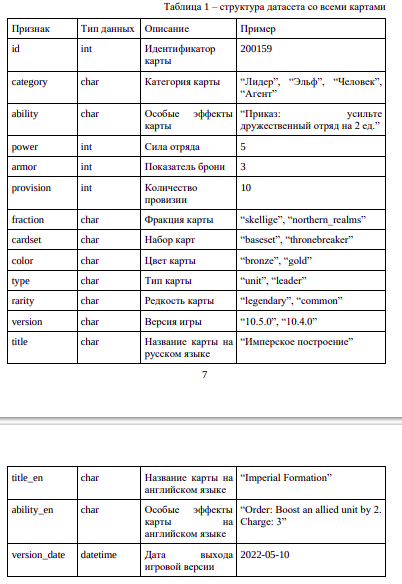

### Структура датасета со всеми колодами
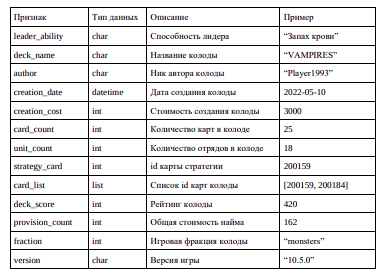


### Структура датасета с результатами матчей
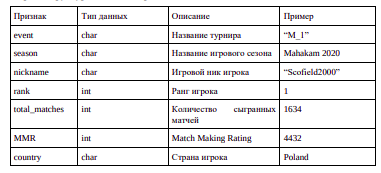


# Сбор данных

## Используемые пакеты

Для сбора данных были использованы следующие прикладные пакеты для языка Python:
1. Requests - для сбора данных со статичных страниц
2. Selenium - для сбора данных с динамических страниц
3. BeautifulSoup - для чтения HTML страниц и получения с них информации
4. Pandas - для соединения полученных данных в таблицы и сохранения в csv фа

## Датасет со всеми картами

Веб-сайты: https://gwent.one/ru/cards/ и https://gwent.one/en/cards/

In [3]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import time
import csv
import sys
import pandas as pd
import os.path

# url базы данных текущей версии релиза
url_ru = 'https://gwent.one/ru/cards/'

url_en = 'https://gwent.one/en/cards/'
"""
Функция для получения списка всех версий
"""
def get_list_verions(url):
    s = Service("/home/anastasia/test_ex/chromedriver/chromedriver")
    driver = webdriver.Chrome(service=s)
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return [version.get("value") for version in soup.findAll('option')]


"""
Функция для получения количества страниц
"""
def get_n_pages(url):
    s = Service("/home/anastasia/test_ex/chromedriver/chromedriver")
    driver = webdriver.Chrome(service=s)
    driver.get(url)
    time.sleep(2)
    driver.find_element(By.XPATH, '//*[@id="pages-top"]/ul')
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return len(soup.find('div', attrs={'class':'search-page'}).findAll('li'))-2



"""
функция для нахождения всех карт в одной релизной версии
url - ссылка на страницу конкретной версии
n_pages - количество страницы с картами
"""
def get_data_per_version(url, version, filename):
    option = webdriver.ChromeOptions()
    chrome_prefs = {}
    option.experimental_options["prefs"] = chrome_prefs
    chrome_prefs["profile.default_content_settings"] = {"images": 2}
    chrome_prefs["profile.managed_default_content_settings"] = {"images": 2}
    s = Service("/home/anastasia/test_ex/chromedriver/chromedriver")
    driver = webdriver.Chrome(service=s, options=option)
    driver.get(url+'?v='+version)
    df = pd.read_csv(filename)
    n_pages = get_n_pages(url+'?v='+version)
    version = version
    count = 0

    for i in range(n_pages):
        time.sleep(1)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        total_cards = soup.find(attrs={'class':'card-count'}).text
        card_info = soup.findAll('div', attrs={'class':'card-wrap card-data'})
        for card in card_info:
            titles = card.findAll('div', attrs={'class': 'card-name'})[0].a.string
            cats = card.findAll('div', attrs={'class': 'card-category'})[0].text
            abilities = card.findAll('div', attrs={'class': 'card-body-ability'})[0].text
            ids = card.get('data-id')
            powers = card.get('data-power')
            armors = card.get('data-armor')
            provisions = card.get('data-provision')
            fractions = card.get('data-faction')
            cardsets = card.get('data-set')
            colors = card.get('data-color')
            types = card.get('data-type')
            rarities = card.get('data-rarity')
            df.loc[len(df)] = [ids, titles, cats, abilities, powers, armors, provisions, fractions, cardsets, colors, types, rarities, version]
            count+=1
        WebDriverWait(driver, 70).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="pages-top"]/ul/li['+str(3+i)+']/a'))).click()
    if df[df.version == version].drop_duplicates().shape[0] == int(total_cards.split(' ')[-1]):
        df.to_csv(filename, index=False)
        print("В версии - ", total_cards, ". Записано - ", count)
        print('Уникальных - ', df[df.version == version].drop_duplicates().shape, " записей")
    else:
        print(version, 'НЕ ЗАПИСАНА')
    driver.quit()


"""
Функция для получения всех словарей с картами каждой версии
"""
def get_data(url, version, filename):
    return get_data_per_version(url, version, filename)

def create_csv(filename):
    df = pd.DataFrame(columns=['id','title','category','ability','power', 'armor','provision','fraction','cardset','color','type','rarity','version'])
    df.to_csv(filename, index=False)

def make_one_csv(filename, url):
    if os.path.exists(filename) == False:
        create_csv(filename)
    df = pd.read_csv(filename)
    list_versions = get_list_verions(url)
    for version in list_versions:
        print(version)
        if version not in df.version.unique():
            get_data(url, version, filename)
            
#make_one_csv('all_cards_en.csv', url_ru)
#make_one_csv('all_cards_ru.csv', url_ru)

## Датасет со всеми колодами

Веб-сайты: https://www.playgwent.com/ru/decks/ и https://gwent.pro/

In [4]:
url = 'https://www.playgwent.com/ru/decks/'

def parse_one_deck(deck_url):
    driver = init_driver()
    driver.get(deck_url)
    time.sleep(2)
    soup = soup_html(driver)
    stats = soup.findAll(attrs={'class':'Point__SinglePointNumber-sc-1h2nwp2-2 jKiSnW'})
    card_count = int(stats[1].text)
    unit_count = int(stats[2].text)
    provision_count = int(stats[3].text)
    cards_list = [card.text for card in soup.findAll(attrs={'class':'Card__CardName-sc-wm0ofx-8 nZJer'})]
    strategy_card = cards_list[0]
    leader_ability = soup.find(attrs={'class':'Card__AbilityName-sc-wm0ofx-15 HkdtI'}).text
    return card_count, unit_count, provision_count, cards_list, strategy_card, leader_ability

def parse_page(driver, filename):
    fraction_dict = {'Item__DeckContainer-sc-qajt96-0 jnpsMq':'monster',
                        'Item__DeckContainer-sc-qajt96-0 kPrVpm':'nilfgaard',
                        'Item__DeckContainer-sc-qajt96-0 iKQfnj':'scoiatael',
                        'Item__DeckContainer-sc-qajt96-0 jaLDry':'syndicate',
                        'Item__DeckContainer-sc-qajt96-0 jExBJf':'northern_realms',
                        'Item__DeckContainer-sc-qajt96-0 itkPLT':'skellige'
                        }
    soup = soup_html(driver)
    df = pd.read_csv(filename)
    # пока активна кнопка "следующая страница"
    while soup.findAll(attrs={'class':'Gradient__GoldGradient-sc-1byp6o7-0 Button__ButtonTextGold-sc-zyy972-1 ismlVO'})[1].get('disabled') is None:
        soup = soup_html(driver)
        for key, value in zip(fraction_dict.keys(), fraction_dict.values()):
            for deck in soup.findAll(attrs={'class': key }):
                deck_link = 'https://www.playgwent.com' + deck.findAll('a')[0].get('href')
                els = [el.text for el in deck.findAll('div')]
                is_best = False
                is_popular = True
                deck_score = int(els[0])
                deck_name = els[3]
                if deck_name in df.deck_name.values:
                    continue
                author = els[5]
                creation_date = els[6]
                creation_cost = int(''.join(str(els[8]).split('\xa0')))
                card_count, unit_count, provision_count, card_list, strategy_card, leader_ability = parse_one_deck(deck_link)
                fraction = value
                print(deck_name)
                df.loc[len(df)] = [deck_name, deck_link, deck_score, author, creation_date, creation_cost, card_count, unit_count, provision_count, card_list, strategy_card, leader_ability, fraction]
                df.to_csv(filename, index = False)
        driver.execute_script("window.scrollTo(0, 1000)")
        time.sleep(1)
        df.to_csv(filename, index = False)
        driver.find_element(By.XPATH, '//*[@id="root"]/div/section/div[3]/a[2]/p').click()
        time.sleep(1)

def parse_deck(url, filename, deck_type):
    driver = init_driver()
    driver.get(url)
    soup = soup_html(driver)
    if deck_type == 'new':
        driver.find_element(By.XPATH, '//*[@id="root"]/div/div[2]/div[1]/ul/li[2]/a').click()
        time.sleep(2)
        soup = soup_html(driver)
        parse_page(driver, filename)
    elif deck_type == 'best':
        driver.find_element(By.XPATH, '//*[@id="root"]/div/div[2]/div[1]/ul/li[3]/a').click()
        time.sleep(2)
        soup = soup_html(driver)
        parse_page(driver, filename)
    else:
        driver.find_element(By.XPATH, '//*[@id="root"]/div/section/div[1]/div[1]/div[2]/div[1]').click()
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="root"]/div/section/div[1]/div[1]/div[1]/div[1]').click()
        time.sleep(2)
        soup = soup_html(driver)
        parse_page(driver, filename)


filename = 'all_decks_gwent_pro.csv'
if os.path.exists(filename) == False:
    pd.DataFrame(columns = ['deck_name', 'deck_link', 'deck_score', 'author', 'creation_date', 'creation_cost', 'card_count', 'unit_count', 'provision_count', 'card_list', 'strategy_card', 'leader_ability', 'fraction', 'game_version', 'event']).to_csv(filename, index = False)

# При выхоже новых версий, можно просто добавить их в этот список
patches = ['10.6','10.5','10.4','10.3','10.2','10.1','9.6.1','9.5.0','9.4.0','9.3.0','9.2.0','9.1.0','9.0.0','8.5.0','8.4.0','8.3.0','8.2.0','8.1.0','8.0.0','7.4.1','7.3.0','7.2.0','7.1.1','7.0.2','6.2.0','6.1.0','5.2.0','5.1.0','4.1.0','4.0.0','3.2.0','1.3.0']

def parse_leader_ability(leader_ability_link):
    r = requests.get(leader_ability_link)
    soup = BeautifulSoup(r.text, 'html.parser')
    data = []
    table = soup.find('table', attrs={'cellpadding':'4'})
    rows = table.findAll('tr')
    for row in rows:
        cols = row.findAll('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    deck_link = table.findAll('a')
    deck_link = [deck_link[i].get('href') for i in range(3, len(deck_link), 4)]
    return data[1:], deck_link

def count_page(leader_ability_link, version):
    r = requests.get(leader_ability_link)
    soup = BeautifulSoup(r.text, 'html.parser')
    data = []
    table = soup.find('table', attrs={'cellpadding':'5'})
    rows = table.findAll('tr')
    for row in rows:
        cols = row.findAll('td')
        for el in cols:
            if version in el.text:
                return int(cols[4].text.split('/')[0]) // 20
    return -1

def parse_deck_gwentpro(deck_link):
    r = requests.get(deck_link)
    soup = BeautifulSoup(r.text, 'html.parser')
    leader_ability = soup.find(attrs={'style':'padding:6; font-size:20px'}).text.split(': ')[1]
    cards = []
    for card in soup.findAll(attrs={'style':'width:300px; font-size:20px; padding:5;'}):
        if card.text[-1] == '2':
            cards.append(card.text[:-2].strip())
            cards.append(card.text[:-2].strip())
        else:
            cards.append(card.text[:-2].strip())
    card_links = [card.find('a').get('href') for card in soup.findAll(attrs={'style':'width:300px; font-size:20px; padding:5;'})]
    return leader_ability, cards

def parse_version(version, filename):
    r = requests.get('https://gwent.pro/?patch=' + version)
    soup = BeautifulSoup(r.text, 'html.parser')
    df = pd.read_csv(filename)
    if version in df.game_version.values:
        return None
    print(version)
    for leader_ability in soup.findAll('div', attrs={'style':'width:100%; display: flex; flex-wrap: wrap;'})[1].findAll('a'):
        leader_ability_link = leader_ability.get('href')
        temp = 0
        n_pages = count_page(leader_ability_link, version)
        if n_pages == -1:
            continue
        if n_pages == 0:
            temp = 1
        for i in range(0, n_pages+temp):
            page = leader_ability_link + '&page=' + str(i)
            print(page)
            data_deck = parse_leader_ability(page)
            deck_links = data_deck[1]
            data_deck = data_deck[0]
            for deck, link in zip(data_deck, deck_links):
                author = deck[6]
                creation_date = deck[1]
                event = deck[2][5:]
                fraction = deck[5]
                game_version = version
                deck_link = link
                leader_ability, cards = parse_deck_gwentpro(deck_link)
                provision_count = '-'
                unit_count = '-'
                creation_cost = '-'
                deck_name = link.split('/')[-1]
                deck_score = '-'
                strategy_card = cards[0]
                card_count = len(cards)
                df.loc[len(df)] = [deck_name, deck_link, deck_score, author, creation_date, creation_cost, card_count, unit_count, provision_count, cards, strategy_card, leader_ability, fraction, game_version, event]
                df.to_csv(filename, index = False)
                print('записано')

## Датасет с результатами матчей

Веб-сайт: https://www.gwentdata.com/leaderboard

In [5]:
url = 'https://www.gwentdata.com/leaderboard'

def get_season_list(driver, filename):
    df = pd.read_csv(filename)
    season = 'M2_10 Cat 2020'
    start = int(input())
    for i in range(start):
        soup = soup_html(driver)
        data = []
        table = soup.find('table', attrs={'class':'mat-table cdk-table mat-sort'})
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            df.loc[len(df)] = [ele for ele in cols if ele] + [season]
        df.to_csv(filename, index = False)
        try:
            driver.find_element(By.XPATH, '/html/body/app-root/div/mat-drawer-container/mat-drawer-content/div[2]/app-leaderboard/div/mat-card-content/div/mat-card/mat-card-footer/mat-paginator/div/div/div[2]/button[3]/span[1]').click()
            time.sleep(3)
        except:
            driver.quit()


# Предобработка некоторых признаков

## Добавление признаков за счёт уже существующих

In [9]:
# Вычисление цены создания колоды, количества отрядов и количества провизии
def calculate_values(deck, version, df_card):
    creation_cost = 0
    unit_count = 0
    provision_count = 0
    for card in deck:
        try:
            rarity = df_card[(df_card.title == card) & (df_card.version == version)].rarity.values[0]
        except:
            return 'to_delete'
        if rarity == 'legendary':
            creation_cost += 800
        elif rarity == 'epic':
            creation_cost += 200
        elif rarity == 'rare':
            creation_cost += 80
        if rarity == 'common':
            creation_cost += 30
        card_type = df_card[(df_card.title == card) & (df_card.version == version)].type.values[0]
        if card_type == 'unit':
            unit_count += 1
        provision_count += df_card[(df_card.title == card) & (df_card.version == version)].provision.values[0]
    return creation_cost, unit_count, provision_count

Тут можно убедиться, что вычисленные признаки добавились:

In [26]:
df_deck = pd.read_csv('all_decks_gwent_pro.csv')
df_deck.head(10)

,Unnamed: 0,deck_name,deck_link,deck_score,author,creation_date,creation_cost,card_count,unit_count,provision_count,card_list,strategy_card,leader_ability,fraction,game_version,event
0,0,11935,https://gwent.pro/decks/11935,-,immortal02,2021.06.26,8280,26,24,163,"['Crystal Skull', 'Amphibious Assault', 'War E...",Crystal Skull,Shieldwall,NR,9.0.0,SPC Gear CUP #1
1,1,11942,https://gwent.pro/decks/11942,-,Demawend-III,2021.06.26,8250,26,22,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,SPC Gear CUP #1
2,2,11478,https://gwent.pro/decks/11478,-,Striklin,2021.06.20,8520,26,22,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,AVG Summer Solstice
3,3,11489,https://gwent.pro/decks/11489,-,Sata_2,2021.06.20,to_delete,26,to_delete,to_delete,"['Crystal Skull', 'Amphibious Assault', 'Erlan...",Crystal Skull,Shieldwall,NR,9.0.0,AVG Summer Solstice
4,4,11530,https://gwent.pro/decks/11530,-,Hansha3,2021.06.20,8140,26,19,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,AVG Summer Solstice
5,5,11545,https://gwent.pro/decks/11545,-,Zad1RaKA,2021.06.20,8470,26,20,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,AVG Summer Solstice
6,6,11161,https://gwent.pro/decks/11161,-,kams134,2021.06.13,8400,26,19,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,Hankook's Tourney #2
7,7,11172,https://gwent.pro/decks/11172,-,expand,2021.06.13,to_delete,26,to_delete,to_delete,"['Tactical Advantage', 'Amphibious Assault', '...",Tactical Advantage,Shieldwall,참치없는참치마요,9.0.0,Hankook's Tourney #2
8,8,11192,https://gwent.pro/decks/11192,-,Darkun-pen,2021.06.13,8400,26,22,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,White Orchard Cup #6
9,9,10985,https://gwent.pro/decks/10985,-,patsy_1998,2021.06.12,8400,26,23,163,"['Crystal Skull', 'Amphibious Assault', 'Virax...",Crystal Skull,Shieldwall,NR,9.0.0,Trynet's TTTTS #38


# Изменение признака

In [77]:
df_decks = pd.read_csv('all_decks.csv')
df_decks.head()

,deck_name,deck_link,deck_score,author,creation_date,creation_cost,card_count,unit_count,provision_count,card_list,strategy_card,leader_ability,fraction
0,TRISS WIGGLE WIGGLE,https://www.playgwent.com/ru/decks/guides/329881,20,TheaBeasty,4 дня назад,5740,25,18,162,"['Проклятый свиток', 'Трисс: метеоритный дождь...",Проклятый свиток,Плоды Ийсгита,monster
1,Triss Relicts/Трисс реликты,https://www.playgwent.com/ru/decks/guides/330019,10,Tech_xx1,3 дня назад,6070,25,23,162,"['Тактическое преимущество', 'Та-Что-Знает', '...",Тактическое преимущество,Плоды Ийсгита,monster
2,ТЕТРАРХИЯ / SPIES 10.6,https://www.playgwent.com/ru/decks/guides/330517,21,DartPrim,2 дня назад,7800,25,14,165,"['Хрустальный череп', 'Бал-маскарад', 'Узурпат...",Хрустальный череп,Заточение,nilfgaard
3,Yenn & Triss Helping Soldier 10.6,https://www.playgwent.com/ru/decks/guides/329803,14,DosenCasualGamer,4 дня назад,8330,25,20,166,"['Хрустальный череп', 'Онейромантия', 'Йеннифэ...",Хрустальный череп,Имперское построение,nilfgaard
4,handbuff/рукоблуд,https://www.playgwent.com/ru/decks/guides/329872,29,Tech_xx1,4 дня назад,6720,25,21,165,"['Хрустальный череп', 'Филавандрель', 'Симлас ...",Хрустальный череп,Бодрость,scoiatael


В поле <b>creation_date</b> даты представлены в виде "4 дня назад" или "2 недели назад". Необходимо всё привети к типу <b>DateTime</b>

In [78]:
df_decks.creation_date.unique()

array(['4 дня назад', '3 дня назад', '2 дня назад', '6 дней назад',
       'день назад', '9 часов назад', '16 часов назад', '5 дней назад',
       '8 часов назад', '6 часов назад', '7 часов назад',
       '15 часов назад', '19 часов назад', '4 часа назад', '7 дней назад',
       '18 часов назад', '14 часов назад', '17 часов назад',
       '20 часов назад', '8 месяцев назад', '10 месяцев назад',
       '5 месяцев назад', 'год назад', '6 месяцев назад',
       '3 месяца назад', '4 месяца назад', '7 месяцев назад',
       '9 месяцев назад', 'месяц назад', '2 месяца назад', '23 дня назад',
       '11 дней назад', '21 день назад', '16 дней назад', '25 дней назад',
       '10 дней назад', '19 дней назад', '17 дней назад', '24 дня назад'],
      dtype=object)

In [79]:
import datetime

def str2DateTime(str_date, date_from):
    date_from = datetime.datetime.strptime(date_from, "%d-%m-%Y").date()
    splited = str_date.split(' ')
    number = int(splited[0]) if len(splited) == 3 else 1
    time = splited[1]
    if time[0] == 'д':
        if number >= date_from.day:
            return datetime.date(date_from.year, date_from.month-1, 31+(date_from.day-number))
        else:
            return datetime.date(date_from.year, date_from.month, date_from.day-number)
    if time[0] == 'ч' or 'минут' in time or 'секунд' in time:
        return  date_from - timedelta(hours=number)
    if 'месяц' in time:
        if number >= date_from.month:
            return datetime.date(date_from.year-1, 12+(date_from.month-number), date_from.day)
        else:
            return datetime.date(date_from.year, date_from.month-number, date_from.day)
    if 'год' in time or 'лет' in time:
        return datetime.date(date_from.year-number, date_from.month, date_from.day)
    
str2DateTime('4 года назад', '18-09-2022')

datetime.date(2018, 9, 18)

In [80]:
df_decks.creation_date = df_decks.creation_date.apply(lambda x: str2DateTime(x, '18-09-2022'))

Тперь можно увидеть, что колонка creation_date имеет необходимый формат

In [82]:
df_decks.head(10)

,deck_name,deck_link,deck_score,author,creation_date,creation_cost,card_count,unit_count,provision_count,card_list,strategy_card,leader_ability,fraction
0,TRISS WIGGLE WIGGLE,https://www.playgwent.com/ru/decks/guides/329881,20,TheaBeasty,2022-09-14,5740,25,18,162,"['Проклятый свиток', 'Трисс: метеоритный дождь...",Проклятый свиток,Плоды Ийсгита,monster
1,Triss Relicts/Трисс реликты,https://www.playgwent.com/ru/decks/guides/330019,10,Tech_xx1,2022-09-15,6070,25,23,162,"['Тактическое преимущество', 'Та-Что-Знает', '...",Тактическое преимущество,Плоды Ийсгита,monster
2,ТЕТРАРХИЯ / SPIES 10.6,https://www.playgwent.com/ru/decks/guides/330517,21,DartPrim,2022-09-16,7800,25,14,165,"['Хрустальный череп', 'Бал-маскарад', 'Узурпат...",Хрустальный череп,Заточение,nilfgaard
3,Yenn & Triss Helping Soldier 10.6,https://www.playgwent.com/ru/decks/guides/329803,14,DosenCasualGamer,2022-09-14,8330,25,20,166,"['Хрустальный череп', 'Онейромантия', 'Йеннифэ...",Хрустальный череп,Имперское построение,nilfgaard
4,handbuff/рукоблуд,https://www.playgwent.com/ru/decks/guides/329872,29,Tech_xx1,2022-09-14,6720,25,21,165,"['Хрустальный череп', 'Филавандрель', 'Симлас ...",Хрустальный череп,Бодрость,scoiatael
5,CHONKIER THAN MY CAT,https://www.playgwent.com/ru/decks/guides/329920,26,TheaBeasty,2022-09-14,7200,25,16,165,"['Зачарованный доспех', 'Филавандрель', 'Зов л...",Зачарованный доспех,Бодрость,scoiatael
6,handbuff triss,https://www.playgwent.com/ru/decks/guides/329830,10,DEVlLDRlVEN,2022-09-14,7150,25,17,165,"['Зачарованный доспех', 'Притворство', 'Симлас...",Зачарованный доспех,Бодрость,scoiatael
7,POISON IS BACK,https://www.playgwent.com/ru/decks/guides/329998,39,TheaBeasty,2022-09-14,8570,25,20,162,"['Глаз тигра', 'Карательница Ведьм', 'Яков: ди...",Глаз тигра,Джекпот,syndicate
8,Poisons-Board Wipe Out,https://www.playgwent.com/ru/decks/guides/330196,10,HeartsandWine,2022-09-15,9460,25,18,162,"['Глаз тигра', 'Падшая Райла', 'Король Нищих',...",Глаз тигра,Джекпот,syndicate
9,TOXIC POCKETS,https://www.playgwent.com/ru/decks/guides/329971,10,DEVlLDRlVEN,2022-09-14,8550,25,18,165,"['Глаз тигра', 'Онейромантия', 'Падшая Райла',...",Глаз тигра,Богатей,syndicate
